# Python Concurrence Programming

![python](https://upload.wikimedia.org/wikipedia/commons/c/c3/Python-logo-notext.svg)
### <center>--by wang liyao (leo)<center> ###

## agenda  ##

-	Multiprocessing
-	Threading/thread
-	Practice






## Multiprocessing



how to start multi process

In [2]:
from multiprocessing import Process
import time 
 
def work(name):
    print('%s start!' % name)
 
 
if __name__ == '__main__':
    p = Process(target=work, args=('child process',))
    p.start()
    if p.is_alive():
        print 'Process: %s is running' % p.pid
    p.join()
    print('main process!')


Process: 15828 is running
main process!


In [3]:
from multiprocessing import Process
 
 
class Work(Process):
    def __init__(self, name):
        super(Work, self).__init__()
        self.name = name
 
    def run(self):
        print('%s start' % self.name)
 
 
if __name__ == '__main__':
    p = Work('child')
    p.start()
    print('main process start')
        

main process start


控制子进程进入不同阶段的是 start(), join(), is_alive(), terminate(), exitcode() 方法，这些方法只能在创建子进程的进程中执行。
创建：创建进程需要一个 function 和相关参数，参数可以是dictProcess(target=func, args=(), kwargs = {})，name 可以用来标识进程
关闭：close停止接收新的任务，如果还有任务来，就会抛出异常。 join 是等待所有任务完成。 join 必须要在 close 之后调用，否则会抛出异常
等待：在UNIX平台上，当某个进程终结之后，该进程需要被其父进程调用wait，否则进程成为僵尸进程(Zombie)。所以在这里，我们调用了Process对象的join()方法 ，实际上等同于wait的作用。 
对于多线程来说，由于只有一个进程，所以不存在此必要性。

结束：terminate() 结束工作进程，不再处理未完成的任务。

由于GIL（全局解释锁）的问题，python多线程并不能充分利用多核处理器。如果想要充分地使用多核CPU的资源，在python中大部分情况需要使用多进程。multiprocessing可以给每个进程赋予单独的Python解释器，这样就规避了全局解释锁所带来的问题。与threading.Thread类似，可以利用multiprocessing.Process对象来创建一个进程。multiprocessing支持子进程、通信和共享数据、执行不同形式的同步，提供了Process、Queue、Pipe、Lock等组件。

In [ ]:
# coding: utf-8

from multiprocessing import Process
import multiprocessing
import time


def task1(msg):
    print 'task1: hello, %s' % msg
    time.sleep(1)


def task2(msg):
    print 'task2: hello, %s' % msg
    time.sleep(1)


def task3(msg):
    print 'task3: hello, %s' % msg
    time.sleep(1)


if __name__ == '__main__':
    p1 = Process(target=task1, args=('one',))
    p2 = Process(target=task2, args=('two',))
    p3 = Process(target=task3, args=('three',))

    start = time.time()

    p1.start()
    p2.start()
    p3.start()

    print("The number of CPU is:" + str(multiprocessing.cpu_count()))
    for p in multiprocessing.active_children():
        print("child p.name: " + p.name + "\tp.id: " + str(p.pid))

    p1.join()
    p2.join()
    p3.join()

    end = time.time()
    print start
    print end
    print('3 processes take %s seconds' % (end - start))

### Lock
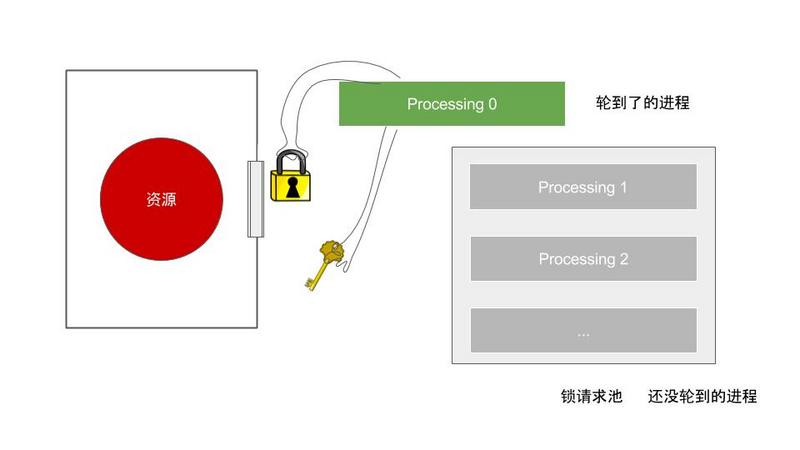


In [ ]:
# coding: utf-8

from multiprocessing import Lock, Process
import time


def task1(lock, f):
    with lock:
        f = open(f, 'w+')
        f.write('hello ')
        time.sleep(1)
        f.close()


def task2(lock, f):
    lock.acquire()
    try:
        f = open(f, 'a+')
        time.sleep(1)
        f.write('world!')
    except Exception as e:
        print(e)
    finally:
        f.close()
        lock.release()


if __name__ == '__main__':
    lock = Lock()
    fn = './file.txt'

    start = time.time()
    p1 = Process(target=task1, args=(lock, fn,))
    p2 = Process(target=task2, args=(lock, fn,))

    p1.start()
    p2.start()

    p1.join()
    p2.join()

    end = time.time()
    print 'time cost: %s seconds' % (end - start)

    with open(fn, 'r') as f:
        for x in f.readlines():
            print x

In [3]:
# coding: utf-8

from multiprocessing import Lock, Process
import time

counter = 0

def task1(lock):
    for i in range(10):
        with lock:
            global counter
            counter += 1

def task2(lock, f):
    lock.acquire()
    try:
        for i in range(10):
            global counter
            counter += 1
    except Exception as e:
        print(e)
    finally:
        lock.release()


if __name__ == '__main__':
    lock = Lock()

    start = time.time()
    p1 = Process(target=task1, args=(lock,))
    p2 = Process(target=task2, args=(lock,))

    p1.start()
    p2.start()

    p1.join()
    p2.join()

    end = time.time()
    print 'time cost: %s seconds' % (end - start)

    print counter

time cost: 0.458999872208 seconds
0


### RLock

RLock是Lock的递归版。
我们知道lock.aquire()是请求锁，当当前的锁事锁定状态的时候，则lock.aquire()则会阻塞等待锁释放。
因此如果我们写了两个lock.aquire()则会产生死锁。第二个lock.aquire()会永远等待在那里。

使用RLock则不会有这种情况。RLock一个门支持多个锁，上多少把锁，就得释放多少次。
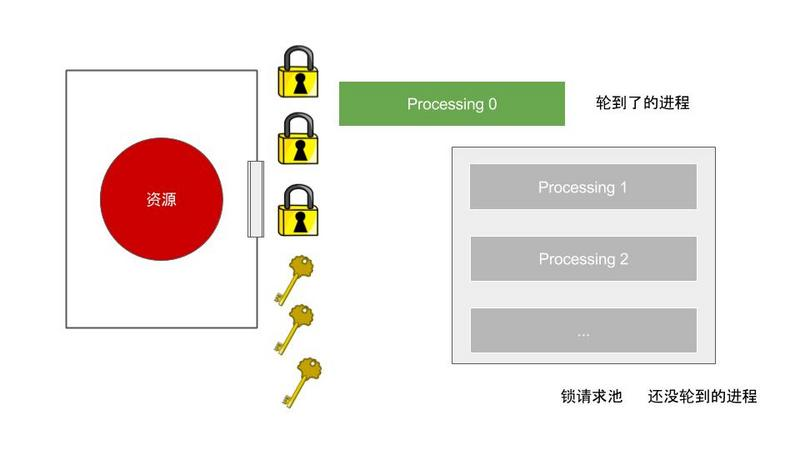

### Semaphore

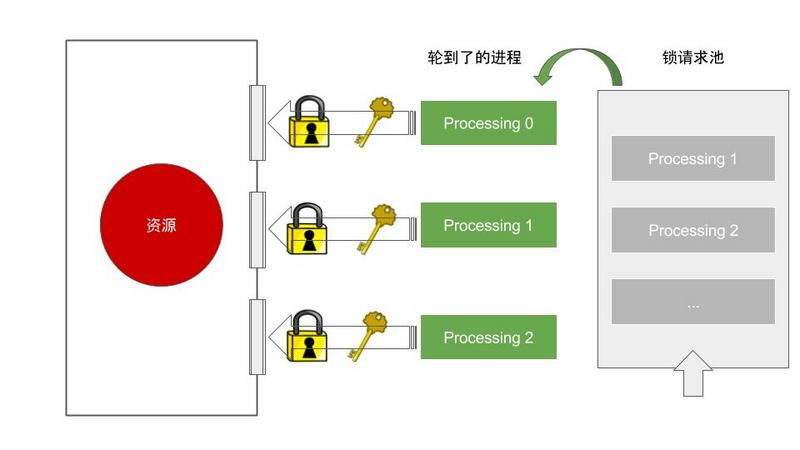
Semaphore 和 Lock 稍有不同，Semaphore 相当于 N 把锁，获取其中一把就可以执行了。 信号量的总数 N 在构造时传入，s = Semaphore(N)。 和 Lock 一样，如果信号量为0，则进程堵塞，直到信号大于0。Semaphore可用来控制对共享资源的访问数量，例如池的最大连接数。

In [7]:
# coding: utf-8

from multiprocessing import Semaphore, Process
import time


def task(s, msg):
    s.acquire()
    print 'hello, %s' % msg
    time.sleep(1)
    s.release()


if __name__ == '__main__':
    s = Semaphore(2)

    processes = []
    for x in range(8):
        p = Process(target=task, args=(s, x,))
        processes.append(p)

    start = time.time()
    for p in processes:
        p.start()

    for p in processes:
        p.join()

    end = time.time()

    print '8 process takes %s seconds' % (end - start)

8 process takes 0.87299990654 seconds


信号量同步基于内部计数器，每调用一次acquire()，计数器减1；每调用一次release()，计数器加1.当计数器为0时，acquire()调用被阻塞。这是Dijkstra信号量概念P()和V()的Python实现。信号量同步机制适用于访问像服务器、文件这样的有限资源。

### Event
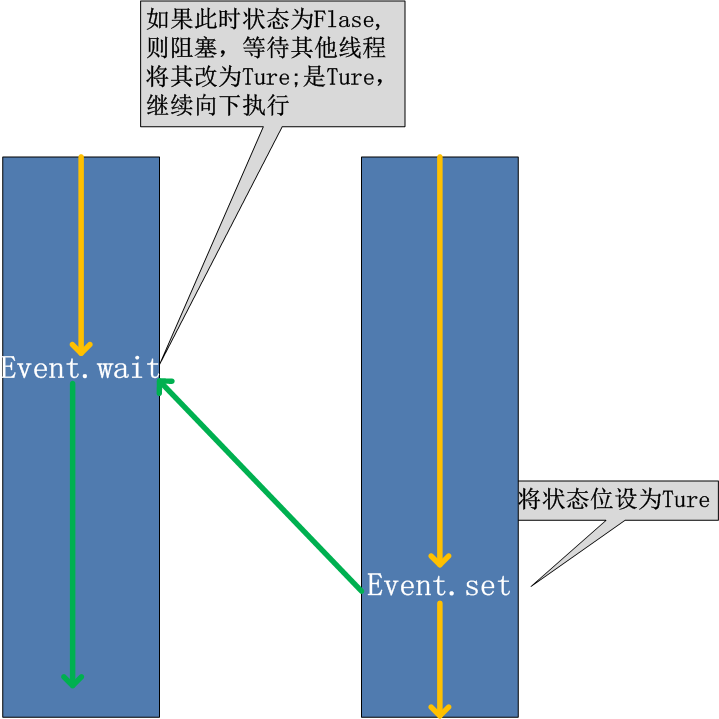

In [1]:
# coding: utf-8

from multiprocessing import Process, Event
import time


def task1(e, msg):
    print 'task1 is waitting...'
    e.wait()
    time.sleep(1)
    print 'hello, %s, e.is_set(): %s' % (msg, e.is_set())


def task2(e, msg):
    print 'task2 is waitting...'
    e.wait(msg)
    print 'hello, %s, e.is_set(): %s' % (msg, e.is_set())


if __name__ == '__main__':
    e = Event()

    p1 = Process(target=task1, args=(e, 1))
    p2 = Process(target=task2, args=(e, 2))

    p1.start()
    p2.start()

    time.sleep(3)

    e.set()
    print 'main: event is set'

main: event is set


### Pool

如果有50个task要执行，但 CPU 只有4核，我们当然可以循环创建50个进程来做这个事情，但这样处理大大增加进程管理和调度的开销。 
如果可以只创建4个进程，让它们轮流工作完成任务，不用我们自己去管理具体的进程的创建、销毁和调度，岂不更好。multiprocessing中的 Pool 可以帮助我们做到这一点。


In [ ]:
# coding: utf-8

from multiprocessing import Pool
import time


def task(msg):
    print 'hello, %s' % msg
    time.sleep(1)


if __name__ == '__main__':
    pool = Pool(processes=2)

    results = []
    for x in range(10):
        ret = pool.apply_async(task, args=(x,))
        results.append(ret)

    pool.close()
    pool.join()

    print 'processes done.'
    for x in results:
        print x.get()

### pool中的map方法

In [ ]:
# coding: utf-8

from multiprocessing import Pool, cpu_count
import time


def task(msg):
    print 'hello, %s' % msg
    time.sleep(1)
    return 'msg: %s' % msg


if __name__ == '__main__':
    pool = Pool(processes=cpu_count())

    results = []
    msgs = [x for x in range(10)]
    results = pool.map(task, msgs)

    pool.close()
    pool.join()

    print 'processes done, result:'

    for x in results:
        print x

### Pipe

multiprocessing.Pipe()
multiprocessing.Pipe()即管道模式，调用Pipe()返回管道的两端的Connection。
> Python官方文档的描述：
> Returns a pair (conn1, conn2) of Connection objects representing the ends of a pipe.

Pipe的读写效率要高于Queue。
进程间的Pipe基于fork机制建立。
当主进程创建Pipe的时候，Pipe的两个Connections连接的的都是主进程。
当主进程创建子进程后，Connections也被拷贝了一份。此时有了4个Connections。
此后，关闭主进程的一个Out Connection，关闭一个子进程的一个In Connection。那么就建立好了一个输入在主进程，输出在子进程的管道


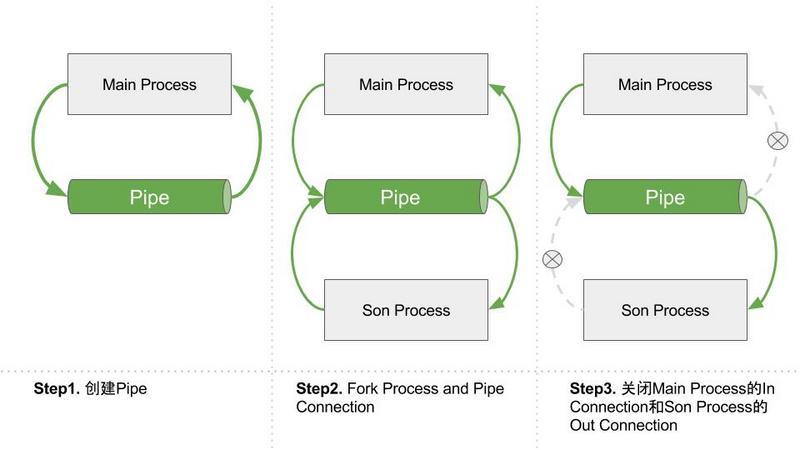

In [ ]:
# 示例代码
# coding=utf-8
from multiprocessing import Pipe, Process


def son_process(x, pipe):
    _out_pipe, _in_pipe = pipe

    # 关闭fork过来的输入端
    _in_pipe.close()
    while True:
        try:
            msg = _out_pipe.recv()
            print msg
        except EOFError:
            # 当out_pipe接受不到输出的时候且输入被关闭的时候，会抛出EORFError，可以捕获并且退出子进程
            break


if __name__ == '__main__':
    out_pipe, in_pipe = Pipe(True)
    son_p = Process(target=son_process, args=(100, (out_pipe, in_pipe)))
    son_p.start()

    # 等pipe被fork 后，关闭主进程的输出端
    # 这样，创建的Pipe一端连接着主进程的输入，一端连接着子进程的输出口
    out_pipe.close()
    for x in range(1000):
        in_pipe.send(x)
    in_pipe.close()
    son_p.join()
    print "主进程也结束了"

### Queue

Queue据官方文档也是基于pipe的实现。
Queue的使用主要是一边put(),一边get().但是Queue可以是多个Process 进行put操作，也可以是多个Process进行get()操作。
队列是一只数据结构，数据存放方式类似于列表，但是取数据的方式不同于列表。

队列的数据有三种方式：

　　1、先进先出（FIFO），即哪个数据先存入，取数据的时候先取哪个数据，同生活中的排队买东西

　　2、先进后出（LIFO），同栈，即哪个数据最后存入的，取数据的时候先取，同生活中手枪的弹夹，子弹最后放入的先打出

　　3、优先级队列，即存入数据时候加入一个优先级，取数据的时候优先级最高的取出
 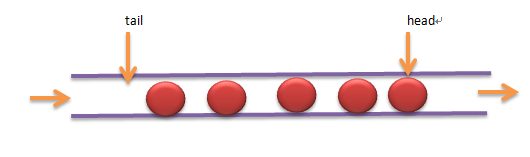


In [ ]:
# coding=utf-8
from multiprocessing import Queue, Process
from Queue import Empty as QueueEmpty
import random


def getter(name, queue):
    print 'Son process %s' % name
    while True:
        try:
            value = queue.get(True, 10)
            # block为True,就是如果队列中无数据了。
            #   |—————— 若timeout默认是None，那么会一直等待下去。
            #   |—————— 若timeout设置了时间，那么会等待timeout秒后才会抛出Queue.Empty异常
            # block 为False，如果队列中无数据，就抛出Queue.Empty异常
            print "Process getter get: %f" % value
        except QueueEmpty:
            break


def putter(name, queue):
    print "Son process %s" % name
    for i in range(0, 1000):
        value = random.random()
        queue.put(value)
        # 放入数据 put(obj[, block[, timeout]])
        # 若block为True，如队列是满的：
        #  |—————— 若timeout是默认None，那么就会一直等下去
        #  |—————— 若timeout设置了等待时间，那么会等待timeout秒后，如果还是满的，那么就抛出Queue.Full.
        # 若block是False，如果队列满了，直接抛出Queue.Full
        print "Process putter put: %f" % value


if __name__ == '__main__':
    queue = Queue()
    getter_process = Process(target=getter, args=("Getter", queue))
    putter_process = Process(target=putter, args=("Putter", queue))
    getter_process.start()
    putter_process.start()


In [ ]:
# coding=utf-8
from multiprocessing import Process,JoinableQueue
import time,random
def consumer(q):
    while True:
        time.sleep(random.randint(1,5))
        res=q.get()
        print('消费者拿到了 %s' %res)
        q.task_done()

def producer(seq,q):
    for item in seq:
        time.sleep(random.randrange(1,2))
        q.put(item)
        print('生产者做好了 %s' %item)
    q.join()

if __name__ == '__main__':
    q=JoinableQueue()
    seq=('包子%s' %i for i in range(10))
    p=Process(target=consumer,args=(q,))
    p.daemon=True #设置为守护进程，在主进程停止时p也停止，但是不用担心，producer内调用q.join保证了consumer已经处理完队列中的所有元素
    p.start()

    producer(seq,q)

    print('主线程')

生产者做好了 包子0
生产者做好了 包子1
生产者做好了 包子2
生产者做好了 包子3
生产者做好了 包子4
生产者做好了 包子5
生产者做好了 包子6
生产者做好了 包子7
生产者做好了 包子8
生产者做好了 包子9


## thread

#### 线程有5种状态，状态转换的过程如下图所示：

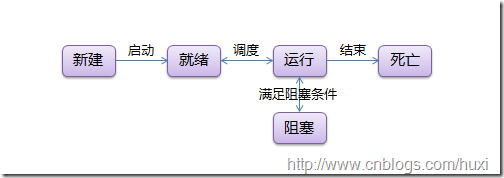


### 所谓的xx生命周期，其实就是某对象的包含产生和销毁的一张状态图。线程的生命周期如下图所示

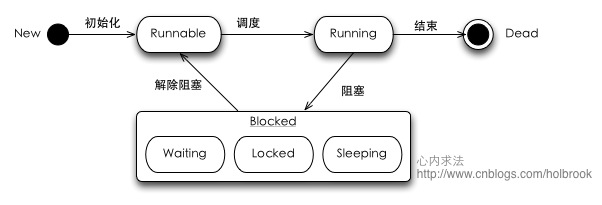


各状态的说明如下：

    New新建。新创建的线程经过初始化后，进入Runnable状态。

    Runnable就绪。等待线程调度。调度后进入运行状态。

    Running运行。

    Blocked阻塞。暂停运行，解除阻塞后进入Runnable状态重新等待调度。

    Dead消亡。线程方法执行完毕返回或者异常终止。





    主线程：当一个程序启动时，就有一个进程被操作系统（OS）创建，与此同时一个线程也立刻运行，该线程通常叫做程序的主线程（Main Thread）。每个进程至少都有一个主线程，主线程通常最后关闭。

    子线程：在程序中创建的其他线程，相对于主线程来说就是这个主线程的子线程。

    守护线程：daemon thread，对线程的一种标识。守护线程为其他线程提供服务，如JVM的垃圾回收线程。当剩下的全是守护线程时，进程退出。

    前台线程：相对于守护线程的其他线程称为前台线程。



线程在执行过程中与进程还是有区别的。每个独立的线程有一个程序运行的入口、顺序执行序列和程序的出口。但是线程不能够独立执行，必须依存在应用程序中，由应用程序提供多个线程执行控制。
每个线程都有他自己的一组CPU寄存器，称为线程的上下文，该上下文反映了线程上次运行该线程的CPU寄存器的状态。
指令指针和堆栈指针寄存器是线程上下文中两个最重要的寄存器，线程总是在进程得到上下文中运行的，这些地址都用于标志拥有线程的进程地址空间中的内存。
线程可以被抢占（中断）。
在其他线程正在运行时，线程可以暂时搁置（也称为睡眠） -- 这就是线程的退让。

### start method

thread.start_new_thread ( function, args[, kwargs] )

>  function - 线程函数。

>  args - 传递给线程函数的参数,他必须是个tuple类型。

>  kwargs - 可选参数。

In [3]:
# -*- coding: UTF-8 -*-
 
import thread
import time
 
# 为线程定义一个函数
def print_time( threadName, delay):
   count = 0
   while count < 5:
      time.sleep(delay)
      count += 1
      print "%s: %s %d" % ( threadName, time.ctime(time.time()), count)
 
# 创建两个线程
try:
   thread.start_new_thread( print_time, ("Thread-1", 0.2, ) )
   thread.start_new_thread( print_time, ("Thread-2", 0.4, ) )
except:
   print "Error: unable to start thread"
 
for i in range(10):
   time.sleep(1)

Thread-1: Sun May 27 19:50:39 2018 1
Thread-2: Sun May 27 19:50:40 2018 1Thread-1: Sun May 27 19:50:40 2018 2

Thread-1: Sun May 27 19:50:40 2018 3
Thread-2: Sun May 27 19:50:40 2018 2
Thread-1: Sun May 27 19:50:40 2018 4
Thread-1: Sun May 27 19:50:40 2018 5
Thread-2: Sun May 27 19:50:40 2018 3
Thread-2: Sun May 27 19:50:41 2018 4
Thread-2: Sun May 27 19:50:41 2018 5


### 使用Threading模块创建线程

> 使用Threading模块创建线程，直接从threading.Thread继承，然后重写__init__方法和run方法：

In [1]:
# -*- coding: UTF-8 -*-
 
import threading
import time
 
exitFlag = 0
 
class myThread (threading.Thread):   #继承父类threading.Thread
    def __init__(self, threadID, name, counter):
        threading.Thread.__init__(self)
        self.threadID = threadID
        self.name = name
        self.counter = counter

    def run(self):                   #把要执行的代码写到run函数里面 线程在创建后会直接运行run函数 
        print "Starting " + self.name
        print_time(self.name, self.counter, 5)
        print "Exiting " + self.name
 
def print_time(threadName, delay, counter):
    while counter:
        if exitFlag:
            (threading.Thread).exit()
        time.sleep(delay)
        print "%s: %s" % (threadName, time.ctime(time.time()))
        counter -= 1
 
# 创建新线程
thread1 = myThread(1, "Thread-1", 1)
thread2 = myThread(2, "Thread-2", 2)
 
# 开启线程
thread1.start()
thread2.start()
 
print "Exiting Main Thread"

Starting Thread-1
Starting Thread-2Exiting Main Thread

Thread-1: Tue May 22 22:03:47 2018
Thread-1: Tue May 22 22:03:48 2018
Thread-2: Tue May 22 22:03:48 2018
Thread-1: Tue May 22 22:03:49 2018
Thread-1: Tue May 22 22:03:50 2018
Thread-2: Tue May 22 22:03:50 2018
Thread-1: Tue May 22 22:03:51 2018
Exiting Thread-1
Thread-2: Tue May 22 22:03:52 2018
Thread-2: Tue May 22 22:03:54 2018


### 线程模块
- Python通过两个标准库thread和threading提供对线程的支持。thread提供了低级别的、原始的线程以及一个简单的锁。
- threading 模块提供的其他方法：
    * threading.currentThread(): 返回当前的线程变量。
    * threading.enumerate(): 返回一个包含正在运行的线程的list。正在运行指线程启动后、结束前，不包括启动前和终止后的线程。
    * threading.activeCount(): 返回正在运行的线程数量，与len(threading.enumerate())有相同的结果。
- 除了使用方法外，线程模块同样提供了Thread类来处理线程，Thread类提供了以下方法:
    * run(): 用以表示线程活动的方法。
    * start():启动线程活动。
    * join([time]): 等待至线程中止。这阻塞调用线程直至线程的join() 方法被调用中止-正常退出或者抛出未处理的异常-或者是可选的超时发生。
    * isAlive(): 返回线程是否活动的。
    * getName(): 返回线程名。
    * setName(): 设置线程名

### lock

In [ ]:
#!/usr/bin/python
# -*- coding: UTF-8 -*-
 
import threading
import time
 
counter = 5
threadLock = threading.Lock()

class ThreadAdd(threading.Thread):
    def __init__(self, threadID, name):
        threading.Thread.__init__(self)
        self.threadID = threadID
        self.name = name

    def run(self):
        print "Starting " + self.name
       # 获得锁，成功获得锁定后返回True
       # 可选的timeout参数不填时将一直阻塞直到获得锁定
       # 否则超时后将返回False
        threadLock.acquire()
        add_function(10)
        # 释放锁
        threadLock.release()

class ThreadSub(threading.Thread):
    def __init__(self, threadID, name):
        threading.Thread.__init__(self)
        self.threadID = threadID
        self.name = name

    def run(self):
        print "Starting " + self.name
       # 获得锁，成功获得锁定后返回True
       # 可选的timeout参数不填时将一直阻塞直到获得锁定
       # 否则超时后将返回False
        threadLock.acquire()
        sub_function(10)
        # 释放锁
        threadLock.release()
 
def add_function(times):
    for i in range(times):
        global counter
        counter += 1
        print '++++', counter
    return counter

def sub_function(times):
    for i in range(times):
        global counter
        counter -= 1
        print '++++', counter
    return counter

threads = []
 
# 创建新线程
thread1 = ThreadAdd(1, "Thread-1")
thread2 = ThreadSub(2, "Thread-2")
 
# 开启新线程
thread1.start()
thread2.start()
 
# 添加线程到线程列表
threads.append(thread1)
threads.append(thread2)
 
# 等待所有线程完成
for t in threads:
    t.join()
print "Exiting Main Thread", counter

###  Condition

Condition（条件变量）通常与一个锁关联。需要在多个Contidion中共享一个锁时，可以传递一个Lock/RLock实例给构造方法，否则它将自己生成一个RLock实例。

可以认为，除了Lock带有的锁定池外，Condition还包含一个等待池，池中的线程处于状态图中的等待阻塞状态，直到另一个线程调用notify()/notifyAll()通知；得到通知后线程进入锁定池等待锁定。

构造方法：
Condition([lock/rlock])

实例方法：
acquire([timeout])/release(): 调用关联的锁的相应方法。
wait([timeout]): 调用这个方法将使线程进入Condition的等待池等待通知，并释放锁。使用前线程必须已获得锁定，否则将抛出异常。
notify(): 调用这个方法将从等待池挑选一个线程并通知，收到通知的线程将自动调用acquire()尝试获得锁定（进入锁定池）；其他线程仍然在等待池中。调用这个方法不会释放锁定。使用前线程必须已获得锁定，否则将抛出异常。
notifyAll(): 调用这个方法将通知等待池中所有的线程，这些线程都将进入锁定池尝试获得锁定。调用这个方法不会释放锁定。使用前线程必须已获得锁定，否则将抛出异常。

In [2]:
import threading
import time
 
# 商品
product = None
# 条件变量
con = threading.Condition()
 
# 生产者方法
def produce():
    global product
    
    if con.acquire():
        while True:
            if product is None:
                print 'produce...'
                product = 'anything'
                
                # 通知消费者，商品已经生产
                con.notify()
            
            # 等待通知
            con.wait()
            time.sleep(2)
 
# 消费者方法
def consume():
    global product
    
    if con.acquire():
        while True:
            if product is not None:
                print 'consume...'
                product = None
                
                # 通知生产者，商品已经没了
                con.notify()
            
            # 等待通知
            con.wait()
            time.sleep(2)
 
t1 = threading.Thread(target=produce)
t2 = threading.Thread(target=consume)
t2.start()
t1.start()

produce...
consume...
produce...
consume...
produce...
consume...
produce...
consume...
produce...
consume...
produce...


* https://blog.csdn.net/u013210620/article/details/78710532

## Q & A